# Imports

In [10]:
import os
os.getcwd()


'/home/neillucha/projects/cdcl-sat-solver/tests/code'

In [11]:
import sys
from pathlib import Path

repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))


In [12]:
import os

path = 'tests/code/stats'
print("Absolute path:", os.path.abspath(path))
print("Exists?", os.path.exists(path))
print("Is directory?", os.path.isdir(path))


Absolute path: /home/neillucha/projects/cdcl-sat-solver/tests/code/tests/code/stats
Exists? False
Is directory? False


In [33]:
from solver.dimacs_parser import DIMACS_Parser, DIMACSParseError
from solver.cnf import CNFFormula, Clause
from solver.cdcl_without_vsids import CDCL as CDCL_No_VSIDS
from solver.cdcl import CDCL as CDCL_VSIDS
from solver.dpll import DPLL
from typing import Optional
from copy import deepcopy
import numpy as np
import time
import pickle
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
random.seed(42)

# Helper Functions

In [16]:
def dict_stats(results_dict):
    stats = {}
    for key, arr in results_dict.items():
        stats[key] = {
            'mean': np.mean(arr),
            'median': np.median(arr),
            'std': np.std(arr),
            'min': np.min(arr),
            'max': np.max(arr)
        }
    return stats

In [52]:
def read_stats_from_file(file: str) -> dict:
    with open('stats/'+file, 'rb') as f:
        test_set_results = pickle.load(f)
    return test_set_results

In [137]:
def build_long_df(data, test_set: str) -> pd.DataFrame:
    rows = []
    for solver in ["CDCL", "CDCL_No_VSIDS", "DPLL"]:
        for metric, values in data[solver].items():
            for v in values:
                rows.append({
                    "solver": solver,
                    "metric": metric,
                    "value": v,
                    "test_set": test_set
                })

    return pd.DataFrame(rows)

In [ ]:
def test(test_set: str, test_size = 10, save_freq=1) -> Optional[dict]:
    
    cnf_dir = (
        Path.cwd().parents[1]
        / "tests"
        / "cnf_files"
        / test_set
    )
    num_files = len(list(cnf_dir.iterdir()))
    results_dict_cdcl = {
        'time_taken': [],
        'num_decisions': [],
        'num_conflicts': [],
        'num_propagations': [],
        'num_learned_clauses': [],
        'max_decision_level': [],
        'time_per_decision': [],
        'conflicts_per_decision': [],
        'propagations_per_decision': [],
        'learned_clauses_per_conflict': []
    }
    results_dict_cdcl_no_vsids = {
        'time_taken': [],
        'num_decisions': [],
        'num_conflicts': [],
        'num_propagations': [],
        'num_learned_clauses': [],
        'max_decision_level': [],
        'time_per_decision': [],
        'conflicts_per_decision': [],
        'propagations_per_decision': [],
        'learned_clauses_per_conflict': []
    }
    results_dict_dpll = {
        'time_taken': [],
        'num_decisions': [],
        'num_conflicts': [],
        'num_propagations': [],
        'max_depth': [],
        'time_per_decision': [],
        'conflicts_per_decision': [],
        'propagations_per_decision': [],
    }
    
    i = 0
    processed_files = []
    items = list(cnf_dir.iterdir())
    random.shuffle(items)
    for cnf_file in items:
        if i%test_size==0:
            break
        i+=1
        print(f"Processing file [{cnf_file.name}] ({i}/{test_size})")
        processed_files.append(cnf_file.name)
        if cnf_file.suffix == '.cnf':
            try:
                parser = DIMACS_Parser(str(cnf_file))
                formula = parser.cnf
                formula1 = deepcopy(formula)
                formula2 = deepcopy(formula)
                formula3 = deepcopy(formula)
                cdcl_no_vsids_solver = CDCL_No_VSIDS(formula1)
                cdcl_vsids_solver = CDCL_VSIDS(formula2)
                dpll_solver = DPLL(formula3)
                
                
                # CDCL without VSIDS
                start_time = time.perf_counter()
                is_sat1 = cdcl_no_vsids_solver.solve()
                end_time = time.perf_counter()
                results_dict_cdcl_no_vsids['time_taken'].append(end_time - start_time)
                results_dict_cdcl_no_vsids['num_decisions'].append(cdcl_no_vsids_solver.num_decisions)
                results_dict_cdcl_no_vsids['num_conflicts'].append(cdcl_no_vsids_solver.num_conflicts)
                results_dict_cdcl_no_vsids['num_propagations'].append(cdcl_no_vsids_solver.num_propagations)
                results_dict_cdcl_no_vsids['num_learned_clauses'].append(cdcl_no_vsids_solver.num_learned_clauses)
                results_dict_cdcl_no_vsids['max_decision_level'].append(cdcl_no_vsids_solver.max_decision_level)
                time_per_decision = end_time - start_time / cdcl_no_vsids_solver.num_decisions if cdcl_no_vsids_solver.num_decisions > 0 else 0
                conflicts_per_decision = cdcl_no_vsids_solver.num_conflicts / cdcl_no_vsids_solver.num_decisions if cdcl_no_vsids_solver.num_decisions > 0 else 0
                prop_per_decision = cdcl_no_vsids_solver.num_propagations / cdcl_no_vsids_solver.num_decisions if cdcl_no_vsids_solver.num_decisions > 0 else 0
                learned_per_conflict = cdcl_no_vsids_solver.num_learned_clauses / cdcl_no_vsids_solver.num_conflicts if cdcl_no_vsids_solver.num_conflicts > 0 else 0
                results_dict_cdcl_no_vsids['time_per_decision'].append(time_per_decision)
                results_dict_cdcl_no_vsids['conflicts_per_decision'].append(conflicts_per_decision)
                results_dict_cdcl_no_vsids['propagations_per_decision'].append(prop_per_decision)
                results_dict_cdcl_no_vsids['learned_clauses_per_conflict'].append(learned_per_conflict)

                # CDCL with VSIDS
                start_time = time.perf_counter()
                is_sat2 = cdcl_vsids_solver.solve()
                end_time = time.perf_counter()
                results_dict_cdcl['time_taken'].append(end_time - start_time)
                results_dict_cdcl['num_decisions'].append(cdcl_vsids_solver.num_decisions)
                results_dict_cdcl['num_conflicts'].append(cdcl_vsids_solver.num_conflicts)
                results_dict_cdcl['num_propagations'].append(cdcl_vsids_solver.num_propagations)
                results_dict_cdcl['num_learned_clauses'].append(cdcl_vsids_solver.num_learned_clauses)
                results_dict_cdcl['max_decision_level'].append(cdcl_vsids_solver.max_decision_level)
                time_per_decision = (end_time - start_time) / cdcl_vsids_solver.num_decisions if cdcl_vsids_solver.num_decisions > 0 else 0
                conflicts_per_decision = cdcl_vsids_solver.num_conflicts / cdcl_vsids_solver.num_decisions if cdcl_vsids_solver.num_decisions > 0 else 0
                prop_per_decision = cdcl_vsids_solver.num_propagations / cdcl_vsids_solver.num_decisions if cdcl_vsids_solver.num_decisions > 0 else 0
                learned_per_conflict = cdcl_vsids_solver.num_learned_clauses / cdcl_vsids_solver.num_conflicts if cdcl_vsids_solver.num_conflicts > 0 else 0
                results_dict_cdcl['time_per_decision'].append(time_per_decision)
                results_dict_cdcl['conflicts_per_decision'].append(conflicts_per_decision)
                results_dict_cdcl['propagations_per_decision'].append(prop_per_decision)
                results_dict_cdcl['learned_clauses_per_conflict'].append(learned_per_conflict)

                # DPLL
                start_time = time.perf_counter()
                is_sat3 = dpll_solver.solve()
                end_time = time.perf_counter()
                results_dict_dpll['time_taken'].append(end_time - start_time)
                results_dict_dpll['num_decisions'].append(dpll_solver.num_decisions)
                results_dict_dpll['num_conflicts'].append(dpll_solver.num_conflicts)
                results_dict_dpll['num_propagations'].append(dpll_solver.num_propagations)
                results_dict_dpll['max_depth'].append(dpll_solver.max_depth)
                time_per_decision = (end_time - start_time) / dpll_solver.num_decisions if dpll_solver.num_decisions > 0 else 0
                conflicts_per_decision = dpll_solver.num_conflicts / dpll_solver.num_decisions if dpll_solver.num_decisions > 0 else 0
                prop_per_decision = dpll_solver.num_propagations / dpll_solver.num_decisions if dpll_solver.num_decisions > 0 else 0
                results_dict_dpll['time_per_decision'].append(time_per_decision)
                results_dict_dpll['conflicts_per_decision'].append(conflicts_per_decision)
                results_dict_dpll['propagations_per_decision'].append(prop_per_decision)

                if is_sat1 != is_sat2 or is_sat1 != is_sat3:
                    print(f"Discrepancy found in file: {cnf_file.name}")
                    return None

                
            except DIMACSParseError as e:
                print(f"Error parsing {cnf_file.name}: {e}")
                continue
            
        if i % save_freq == 0:
            print('SAVING INTERMEDIATE RESULTS...')
            intermediate_results = {
                'processed_files': processed_files,
                'num_files_processed': len(processed_files),
                'CDCL': results_dict_cdcl,
                'CDCL_No_VSIDS': results_dict_cdcl_no_vsids,
                'DPLL': results_dict_dpll
            }
            with open(f'stats/intermediate_results_{test_set}.pkl', 'wb') as f:
                pickle.dump(intermediate_results, f)
    
    
    print('SAVING FINAL RESULTS...')
    final_results = {
        'processed_files': processed_files,
        'num_files_processed': len(processed_files),
        'CDCL': results_dict_cdcl,
        'CDCL_No_VSIDS': results_dict_cdcl_no_vsids,
        'DPLL': results_dict_dpll
    }
    with open(f'stats/final_results_{test_set}.pkl', 'wb') as f:
        pickle.dump(final_results, f)

    for key, arr in results_dict_cdcl.items():
        results_dict_cdcl[key] = dict_stats({key: arr})[key]
        
    for key, arr in results_dict_cdcl_no_vsids.items():
        results_dict_cdcl_no_vsids[key] = dict_stats({key: arr})[key]

    for key, arr in results_dict_dpll.items():
        results_dict_dpll[key] = dict_stats({key: arr})[key]

    test_set_results = {
        'CDCL': results_dict_cdcl,
        'CDCL_No_VSIDS': results_dict_cdcl_no_vsids,
        'DPLL': results_dict_dpll
    }
    
    print('SAVING AGGREGATE RESULTS...')
    with open(f'stats/aggregate_results_{test_set}.pkl', 'wb') as f:
        pickle.dump(test_set_results, f)
    return test_set_results


# Running Tests

In [32]:
aggregated_test_results_dict = {}

In [91]:
test_sets = [
    'uf75-325',
    'uuf75-325',
    "CBS_k3_n100_m403_b10", 
    "CBS_k3_n100_m403_b50",
    "CBS_k3_n100_m403_b90",
    'CBS_k3_n100_m449_b10',
    'CBS_k3_n100_m449_b50',
    'CBS_k3_n100_m449_b90',
    ]

mini_test_sets = [
    'uf75-325',
    'uuf75-325',
]

used_test_sets = test_sets

for i, test_set in enumerate(used_test_sets):
    print('----------------------------------------')
    print(f"Running tests on test set: {test_set} {i+1}/{len(used_test_sets)}")
    aggregated_test_set_results_dict = test(test_set, test_size=5)
    aggregated_test_results_dict[test_set] = aggregated_test_set_results_dict

----------------------------------------
Running tests on test set: uf75-325 1/8
Processing file [uf75-018.cnf] (1/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uf75-023.cnf] (2/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uf75-080.cnf] (3/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uf75-058.cnf] (4/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uf75-038.cnf] (5/5)
SAVING FINAL RESULTS...
SAVING AGGREGATE RESULTS...
----------------------------------------
Running tests on test set: uuf75-325 2/8
Processing file [uuf75-038.cnf] (1/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uuf75-074.cnf] (2/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uuf75-051.cnf] (3/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uuf75-042.cnf] (4/5)
SAVING INTERMEDIATE RESULTS...
Processing file [uuf75-078.cnf] (5/5)
SAVING FINAL RESULTS...
SAVING AGGREGATE RESULTS...
----------------------------------------
Running tests on test set: CBS_k3_n100_m403_b10 3/8
Processing file [

In [93]:
aggregated_dataframe = pd.DataFrame()
for test_set, results in aggregated_test_results_dict.items():
    for solver_name, stats in results.items():
        for metric, metric_stats in stats.items():
            row = {
                'test_set': test_set,
                'solver': solver_name,
                'metric': metric,
                **metric_stats
            }
            aggregated_dataframe = pd.concat([aggregated_dataframe, pd.DataFrame([row])], ignore_index=True)

In [95]:
raw_dataframes_dict = {}
for test_set in used_test_sets:
    final_stats = read_stats_from_file(f'final_results_{test_set}.pkl')
    df = build_long_df(final_stats, test_set)
    raw_dataframes_dict[test_set] = df

raw_df = pd.concat(raw_dataframes_dict.values(), ignore_index=True)



# Visualizations

### Runtime Distribution and Variability Comparison

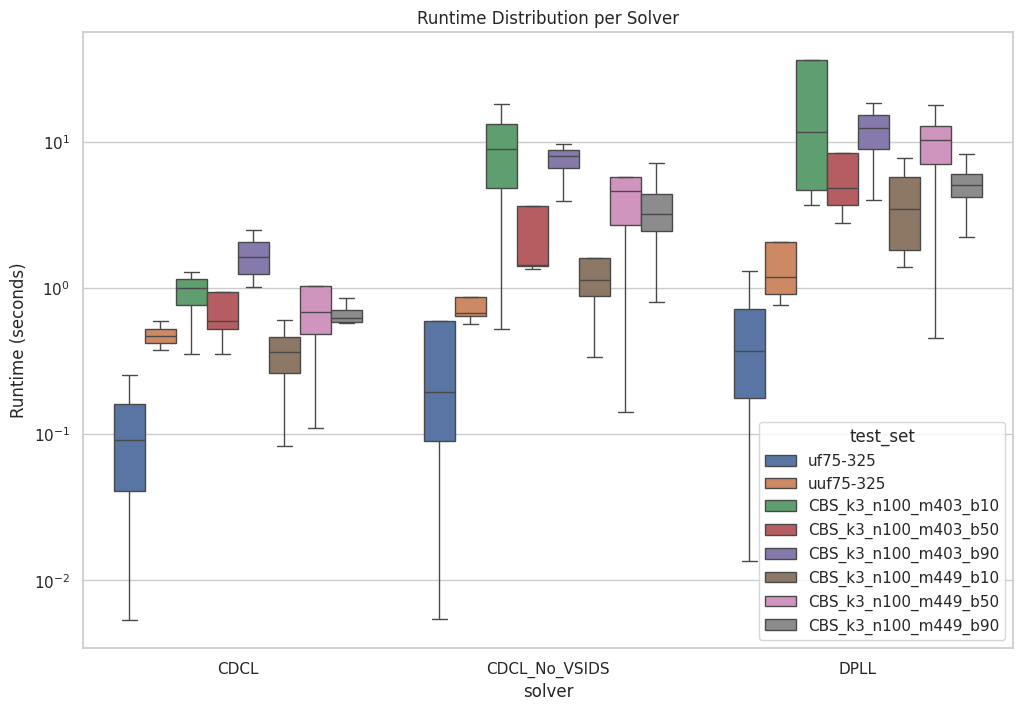

In [108]:
runtime_df = raw_df[raw_df["metric"] == "time_taken"]

mean_df = (
    runtime_df
    .groupby("solver")["value"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=runtime_df,
    x="solver",
    y="value",
    hue="test_set",
    showfliers=False
)


plt.yscale("log")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Distribution per Solver")
plt.show()


### Average Runtime Heatmap per Dataset

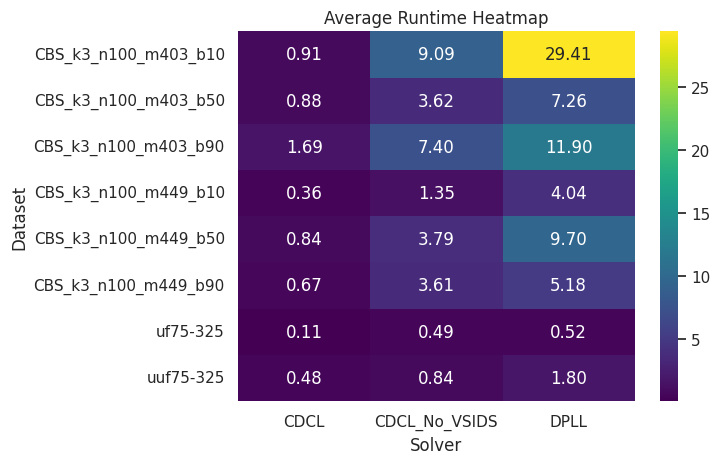

In [97]:
heat_df = (
    raw_df[raw_df["metric"] == "time_taken"]
    .groupby(["test_set", "solver"])["value"]
    .mean()
    .reset_index()
    .pivot(index="test_set", columns="solver", values="value")
)

sns.heatmap(
    heat_df,
    annot=True,
    fmt=".2f",
    cmap="viridis"
)

plt.title("Average Runtime Heatmap")
plt.ylabel("Dataset")
plt.xlabel("Solver")
plt.show()


### Effect of VSIDS

Defining Gain as Ratio of Decisions without VSIDS to Decisions with VSIDS

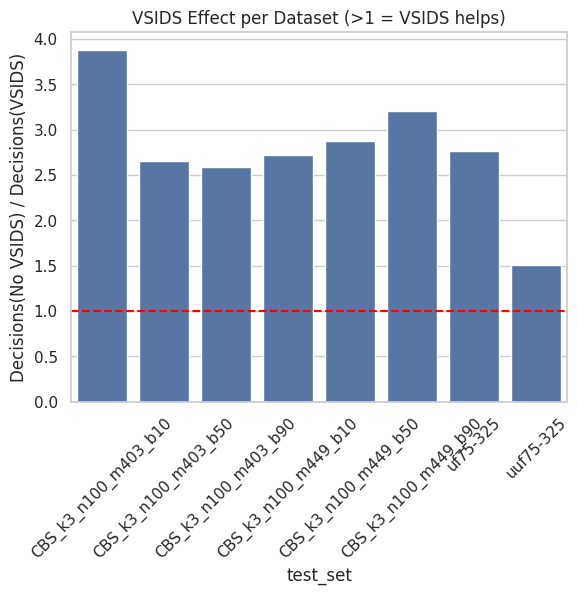

In [98]:
pivot = raw_df[
    raw_df["metric"] == "num_decisions"
].pivot_table(
    index=["test_set"],
    columns="solver",
    values="value",
    aggfunc="mean"
).reset_index()

pivot["vsids_gain"] = (
    pivot["CDCL_No_VSIDS"] / pivot["CDCL"]
)

sns.barplot(
    data=pivot,
    x="test_set",
    y="vsids_gain"
)

plt.axhline(1.0, linestyle="--", color="red")
plt.ylabel("Decisions(No VSIDS) / Decisions(VSIDS)")
plt.title("VSIDS Effect per Dataset (>1 = VSIDS helps)")
plt.xticks(rotation=45)
plt.show()


### Conflicts vs Decisions Scatter Plot

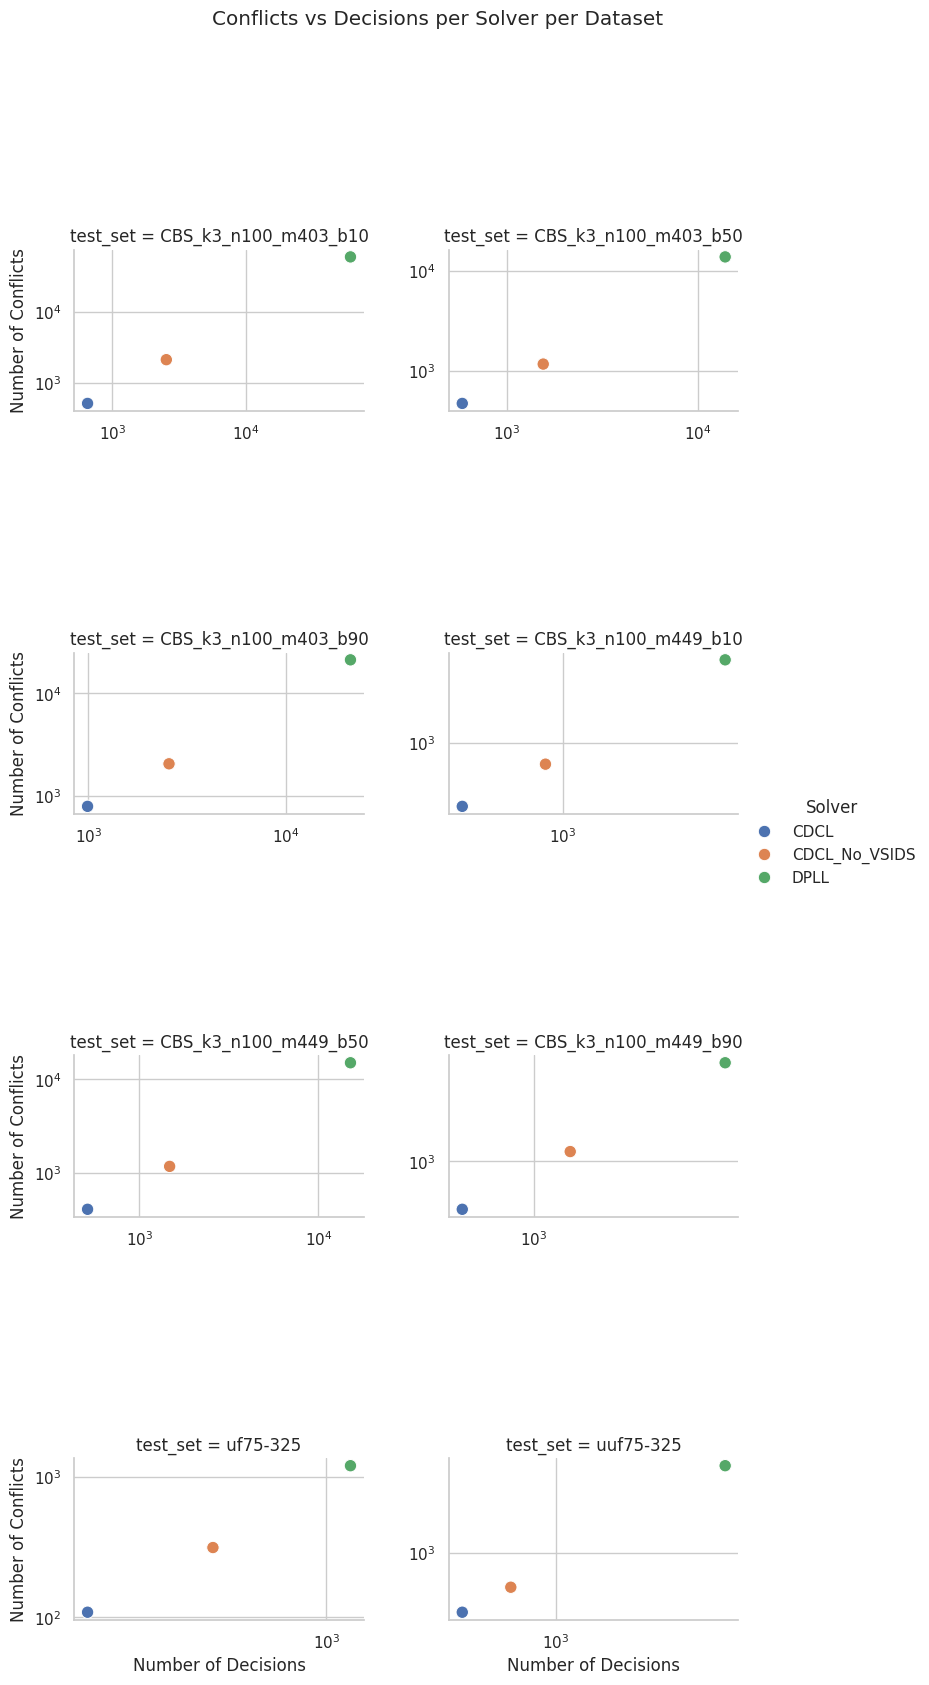

In [131]:
df = raw_df[raw_df["metric"].isin(["num_decisions", "num_conflicts"])]
# Pivot table for easy plotting
pivot = df.pivot_table(
    index=["test_set", "solver"],
    columns="metric",
    values="value",
    aggfunc="mean"
).reset_index()

# FacetGrid per test set
g = sns.FacetGrid(pivot, col="test_set", col_wrap=2, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="num_decisions", y="num_conflicts", hue="solver", s=80)
g.add_legend(title="Solver")
g.set_axis_labels("Number of Decisions", "Number of Conflicts")
for ax in g.axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
plt.subplots_adjust(top=0.9, hspace=1.5)
g.figure.suptitle("Conflicts vs Decisions per Solver per Dataset", y=1.05)
plt.show()

### Runtime ECDF per solver

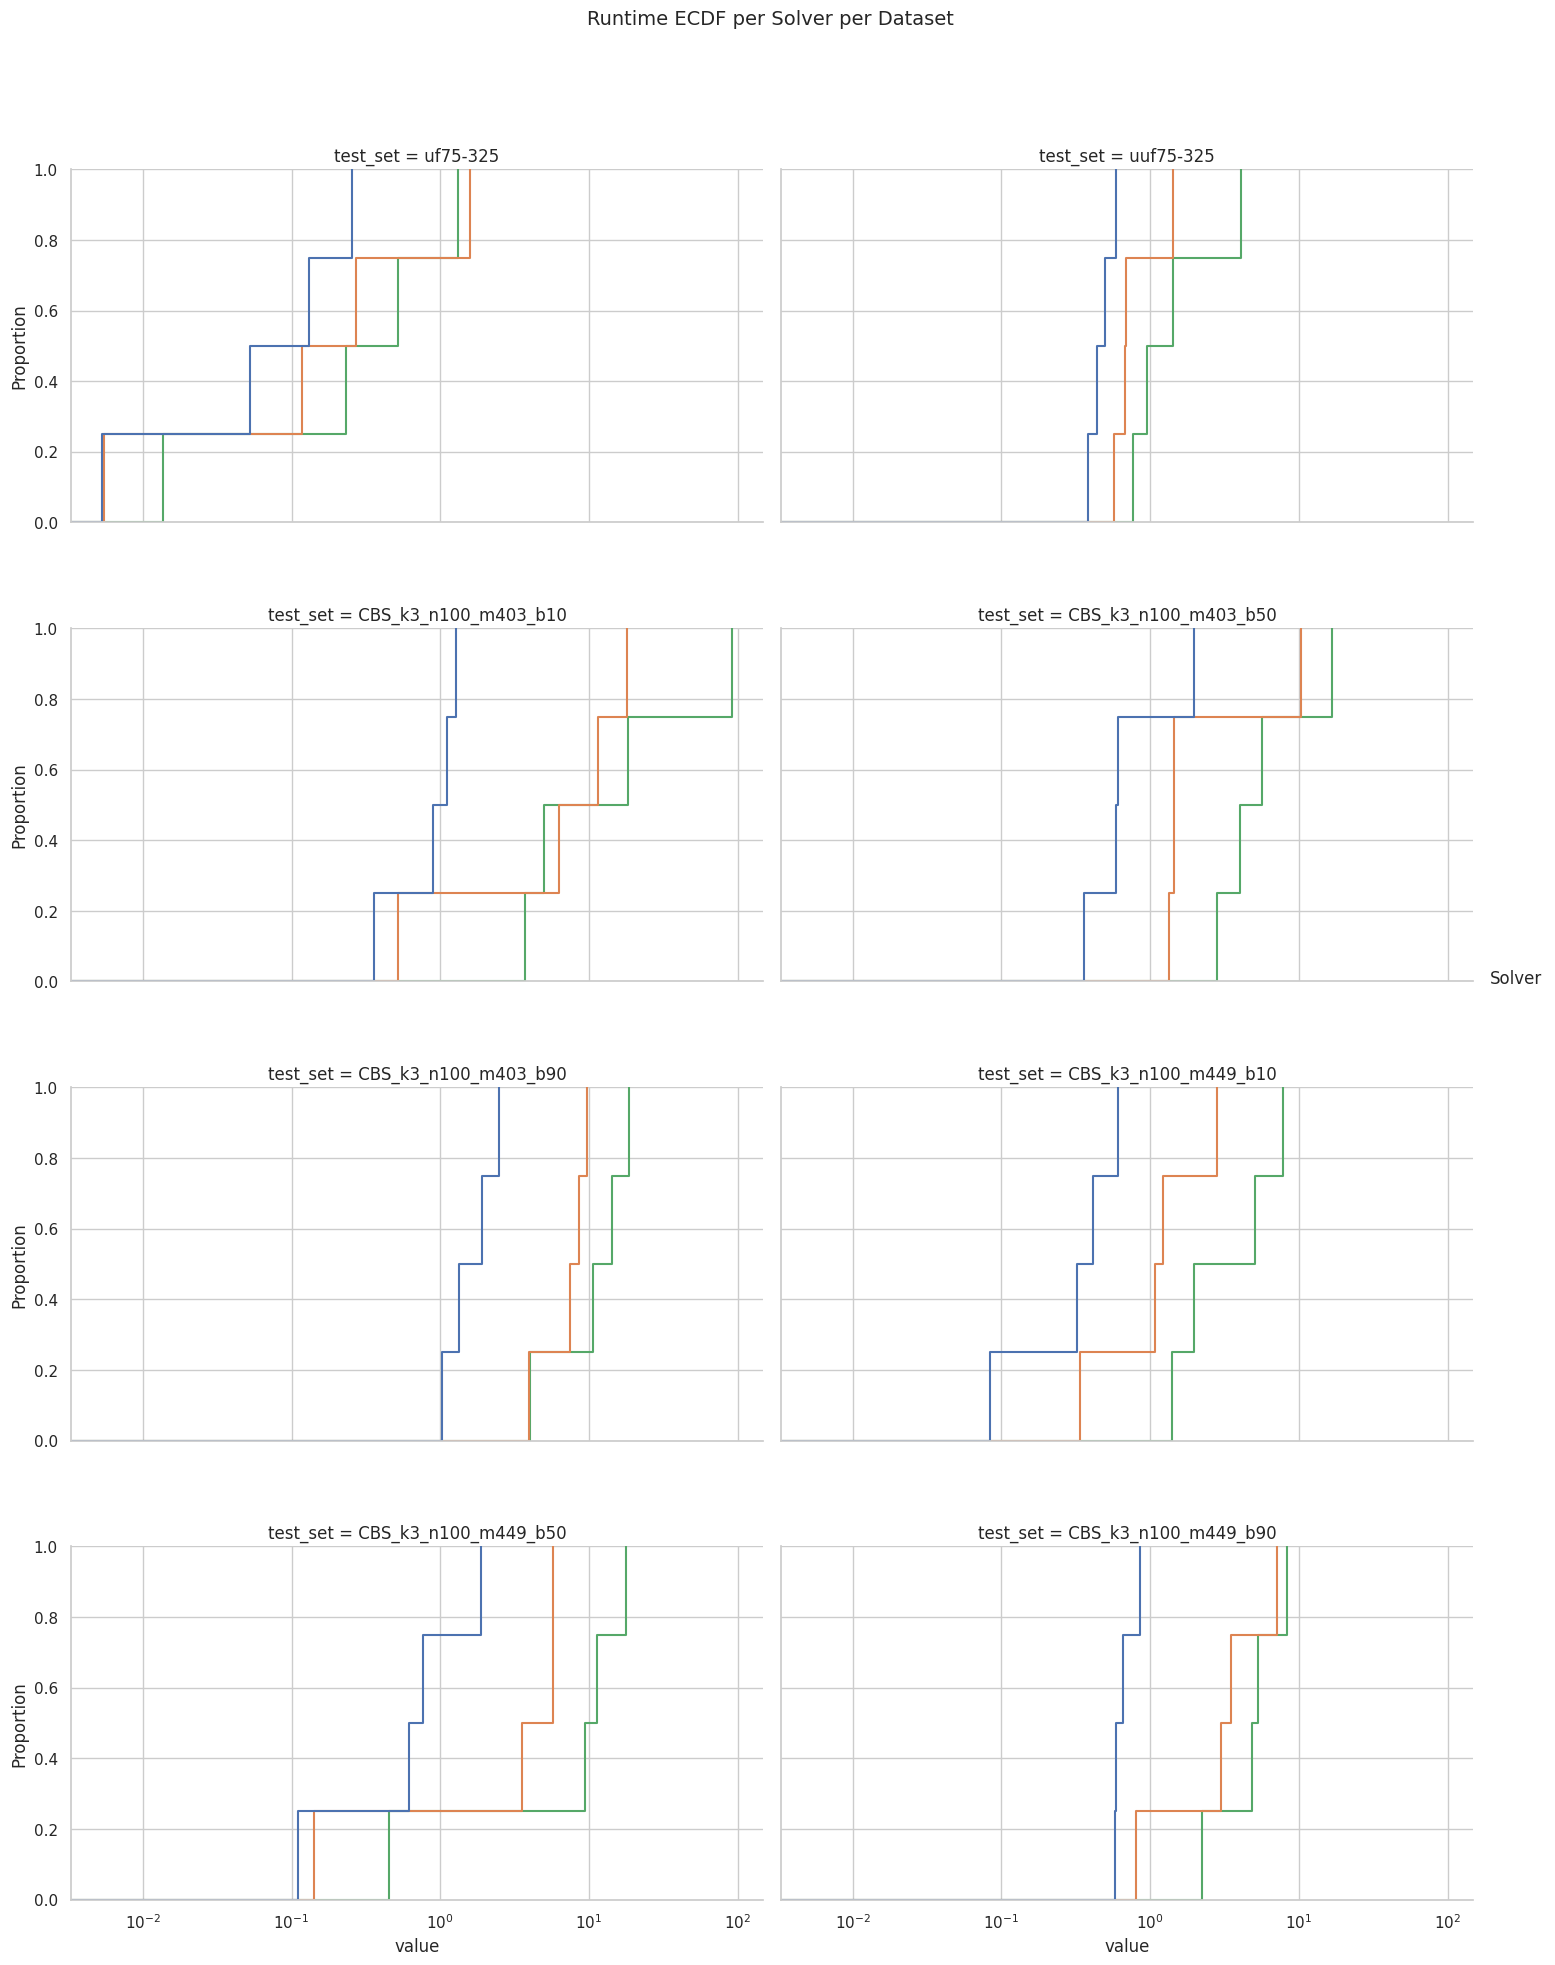

In [136]:
g = sns.FacetGrid(
    raw_df[raw_df["metric"] == "time_taken"],
    col="test_set",
    sharey=True,
    col_wrap=2,
    height=5,      # taller plots
    aspect=1.5     # wider plots
)
g.map_dataframe(sns.ecdfplot, x="value", hue="solver")
g.add_legend(title="Solver")
plt.subplots_adjust(top=0.9, hspace=0.3)
for ax in g.axes.flatten():
    ax.set_xscale("log")
g.figure.suptitle("Runtime ECDF per Solver per Dataset", fontsize=14)
plt.show()
